# Predicting Reddit Post Metadata

#### by Parker Erickson and Frank Piva
#### December 13, 2019

## Introduction
In this notebook we are going to use the title of a Reddit post to train a Naive Bayes model that will predict the subreddit the post belongs to. Reddit is an collection of community operated online forums where people can make and view posts on user created pages ("SubReddits"). 

***Disclaimer: the information is directly from a public website and may contain harsh language or upsetting content.***

### Summary of Imports

In [1]:
# initialize the environment
from scipy.stats import zscore
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import math

PAGE_COUNT = 5
RANDOM_STATE = 0
TEST_SIZE = 0.25

—————————————————————————————————————————————————————————————————————————————————————————————————————————————————

## Data Gathering and Preprocessing

We are going to dynamically generate the dataset in this notebook by making a request to Reddit's API and parsing the response. Our method will accept a page count parameter, for the number of pages of data to request. Each page contains 25 posts. Each post contains a plethora of metadata, but we are only going to extract the title, subreddit, ups (number of upvotes), and created_utc (publication date).

In [2]:
def get_reddit_data(page_count):
    print('fetching your data, * = 1 request to the Reddit API')
    headers = {'User-Agent': 'Predicting Reddit Post Metadata'}
    posts = []
    top_subreddits = [ 'r/europe', 'r/dataisbeautiful', 'r/TrueOffMyChest',
            'r/Futurology', 'r/personalfinance', 'r/madlads', 'r/Music',
            'r/PublicFreakout', 'r/unpopularopinion', 'r/Boxing'
    ]
    for i in range(len(top_subreddits)):
        after = ''
        for j in range(page_count):
            print('*', end='')
            url = 'https://www.reddit.com/'+ top_subreddits[i] + '/top.json?t=all&after=' + after
            #print(url)
            response = requests.get(url, headers=headers)    
            for k in range(len(response.json()['data']['children'])):
                post = {}
                post['created_utc'] = int(response.json()['data']['children'][k]['data']['created_utc'])
                post['is_video'] = int(response.json()['data']['children'][k]['data']['is_video'])
                post['subreddit'] = response.json()['data']['children'][k]['data']['subreddit']
                post['title'] = response.json()['data']['children'][k]['data']['title']
                post['total_awards_received'] = response.json()['data']['children'][k]['data']['total_awards_received']
                post['ups'] = response.json()['data']['children'][k]['data']['ups']
                posts.append(post)
            after = response.json()['data']['after']    
    return posts

columns = ['created_utc', 'is_video', 'subreddit', 'title', 'total_awards_received', 'ups']
df = pd.DataFrame(get_reddit_data(PAGE_COUNT), columns=columns)
df = df.sample(frac=1, random_state=RANDOM_STATE)

fetching your data, * = 1 request to the Reddit API
**************************************************

—————————————————————————————————————————————————————————————————————————————————————————————————————————————————

## Data Inspection

This block of code will print a good representation of our main data. What it shows under 'df.Describe():' is an overview of how the data is distributed, and shows the count, mean, standard deviation, minimum, and the max. 

Next, 'df.info()' shows the overall characteristics of the information in the dataset. This here shows 5000 rows of data across 4 columns, as well as the data types. 

Furthermore, df.head(10) is displaying the first ten lines of the dataset just to  show us how it looks, and that it is correct. 

As well, we can see that there are no NA values in this data from 'df.isna().sum().'

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

print('df.Describe():\n', df.describe(), '\n')
print(df.info(), '\n')
print('df.head(10):\n', df.head(10), '\n')
print('SUM OF NA VALUES:\n', df.isna().sum(), '\n')

df.Describe():
         created_utc     is_video  total_awards_received            ups
count  1.250000e+03  1250.000000            1250.000000    1250.000000
mean   1.545642e+09     0.117600               2.918400   40073.700000
std    2.730765e+07     0.322263               6.767894   24217.376611
min    1.424474e+09     0.000000               0.000000    1667.000000
25%    1.529189e+09     0.000000               0.000000   19887.250000
50%    1.552756e+09     0.000000               1.000000   41142.000000
75%    1.567859e+09     0.000000               3.000000   56553.250000
max    1.576309e+09     1.000000             152.000000  146986.000000 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1250 entries, 711 to 684
Data columns (total 6 columns):
created_utc              1250 non-null int64
is_video                 1250 non-null int64
subreddit                1250 non-null object
title                    1250 non-null object
total_awards_received    1250 non-null int64
ups      

## Data Exploration and Visualization

in the next step we look at our numeric values to see if they correlate. Overall, when comparing amount of  upvotes(when someone on reddit likes the post) to the amount of time since it was created we can assume that the plot will be weighted whichever way the most amount of time has passed.

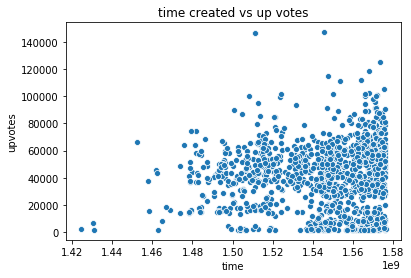

In [13]:

sns.scatterplot('created_utc', 'ups', data = df)
plt.title("time created vs up votes")
plt.xlabel("time")
plt.ylabel("upvotes");

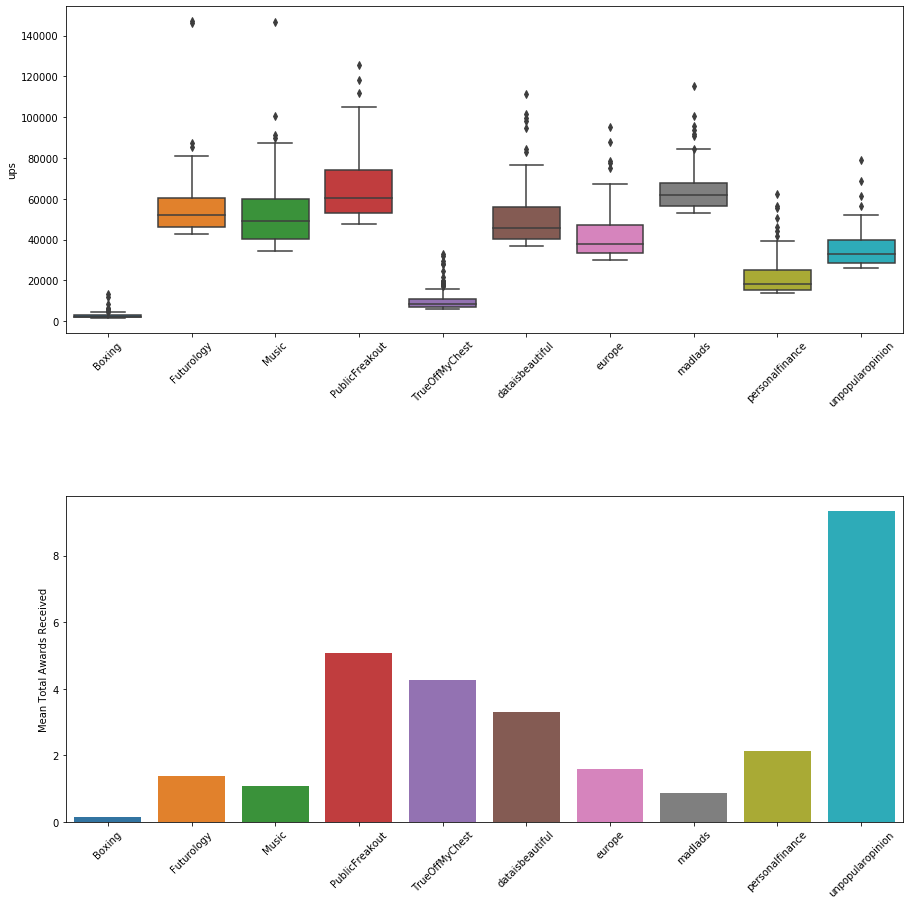

In [5]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
plt.subplot(211)
sns.boxplot(x='subreddit', y='ups', data=df, order=df['subreddit'].value_counts().sort_index().index)
plt.xlabel('')
plt.xticks(rotation=45);

plt.subplot(212)
s = df.groupby(['subreddit'])['total_awards_received'].mean().sort_index(axis=0)
sns.barplot(s.index, s.values)
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('Mean Total Awards Received');

TODO: Talk about the graph.

—————————————————————————————————————————————————————————————————————————————————————————————————————————————————

## Naive Bayes: Predict the Subreddit from the Title

In our preliminary exploration we will train on 250 examples, or roughly 1 page of data from every subreddit. The report that is generated tells us the 10 most frequent categories the model trained on, tested on, and predicted. It will also generate the baseline accuracy (the number of examples of the most frequent subreddit in the test data set divided by the total number of examples in the test data set) and the accuracy of our model.

In [6]:
def train_predict_report(tprdf, print_info=True):
    X = tprdf['title'].values
    y = tprdf['subreddit'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=0)
    model = make_pipeline(TfidfVectorizer(), MultinomialNB())
    model.fit(X_train, y_train);
    y_predict = model.predict(X_test)
    accuracy = (y_predict == y_test).mean()
    baseline = pd.Series(y_test).value_counts()[0] / pd.Series(y_test).value_counts().sum()
    prediction_count = pd.Series(y_test).value_counts().sum()
    if (print_info):
        print('VC of y_train')
        print(pd.Series(y_train).value_counts()[:10], '\n')
        print('VC of y_test')
        print(pd.Series(y_test).value_counts()[:10], '\n')
        print('VC of y_predict')
        print(pd.Series(y_predict).value_counts()[:10], '\n')
        print('# PRDCTN: ', prediction_count)
        print('BASELINE: ', baseline)
        print('ACCURACY: ', accuracy)
        print(len(y_test), len(y_predict))       
    return accuracy

train_predict_report(df[0:250])

VC of y_train
madlads             25
PublicFreakout      23
Futurology          22
Music               20
unpopularopinion    18
TrueOffMyChest      17
dataisbeautiful     17
europe              16
Boxing              15
personalfinance     14
dtype: int64 

VC of y_test
personalfinance     11
unpopularopinion     9
Boxing               7
europe               7
Futurology           7
TrueOffMyChest       5
PublicFreakout       5
madlads              5
Music                4
dataisbeautiful      3
dtype: int64 

VC of y_predict
Futurology          20
PublicFreakout      19
madlads             12
unpopularopinion     3
dataisbeautiful      3
Boxing               2
Music                2
personalfinance      1
TrueOffMyChest       1
dtype: int64 

# PRDCTN:  63
BASELINE:  0.1746031746031746
ACCURACY:  0.3968253968253968
63 63


0.3968253968253968

Here we see that with only 187 examples to train on, our model does better than making a baseline prediction. We will now double the amount of training examples, and examine the effects of more data on the accuracy our predictions.

In [7]:
train_predict_report(df[0:500])

VC of y_train
PublicFreakout      47
madlads             44
unpopularopinion    41
Boxing              40
Futurology          39
Music               37
TrueOffMyChest      35
europe              34
personalfinance     33
dataisbeautiful     25
dtype: int64 

VC of y_test
dataisbeautiful     16
Futurology          15
TrueOffMyChest      14
unpopularopinion    14
Boxing              13
europe              13
personalfinance     13
madlads             11
Music                9
PublicFreakout       7
dtype: int64 

VC of y_predict
PublicFreakout      36
unpopularopinion    26
Futurology          24
Boxing              12
TrueOffMyChest      10
madlads              7
dataisbeautiful      5
personalfinance      4
Music                1
dtype: int64 

# PRDCTN:  125
BASELINE:  0.128
ACCURACY:  0.456
125 125


0.456

Excellent; with more training examples our model yields better accuracy. We will now graph the accuracy of our model against how examples it trained on.


 [187, 375, 562, 750, 937] [0.3968253968253968, 0.456, 0.5, 0.564, 0.6293929712460063]


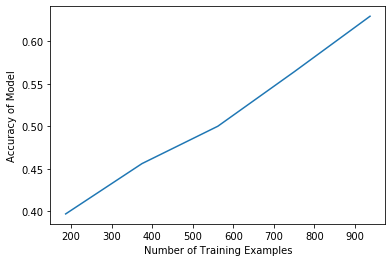

In [8]:
x = []
y = []
for i in range(PAGE_COUNT):
    x.append(int(math.floor((i+1)*250*(1-TEST_SIZE))))
    y.append(train_predict_report(df[0:(i+1)*250], print_info=False))
print('\n',x,y)
plt.plot(x,y)
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy of Model');


——————————————————————————————————————————————————————————————————————

## Logistic Regression: Predict if Post is a Video

In this section we are using Logistic Regression to classify whether a Reddit post is a video or not. Reddit posts are usually singular types of content — photo, video, or text. To acheive this we are using the subreddit data and measure the length of the title to use as features. Because the data got split into so many columns, its important to do feature selection to decrease sensitivity to certain features and prevent overfitting.

In [9]:
tempdf = df.loc[:, ['subreddit', 'title', 'is_video']]

#get the length of each title and put that into a new column.
tempdf['title_len'] = df['title'].apply(lambda x: len(x))
LRdf = pd.get_dummies(tempdf, columns=['subreddit'], drop_first = True)

# set the features to use in testing and training
features = LRdf.drop(['is_video', 'title'], axis=1)
X=features.values
y=LRdf['is_video'].values



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state = 0)

remaining = list(range(X_train.shape[1]))
selected = []
n = 10
while len(selected) < n:   
    # find the single features that works best in conjunction
    # with the already selected features
    acc_max = -1
    for i in remaining:
        X_i = X_train[:,selected+[i]]
        scores = cross_val_score(LogisticRegression(solver = 'liblinear'), X_i, y_train, scoring='accuracy', cv=3)
        acc = scores.mean()
        if acc > acc_max:
            acc_max = acc
            i_min = i 
    remaining.remove(i_min)
    selected.append(i_min)
    print('num features: {}; accuracy: {:.4f}'.format(len(selected), acc_max))
    
print('\nSELECTED FEATURES:', features.columns[selected])

1250
num features: 1; accuracy: 0.9477
num features: 2; accuracy: 0.9477
num features: 3; accuracy: 0.9477
num features: 4; accuracy: 0.9477
num features: 5; accuracy: 0.9477
num features: 6; accuracy: 0.9477
num features: 7; accuracy: 0.9477
num features: 8; accuracy: 0.9477
num features: 9; accuracy: 0.9477
num features: 10; accuracy: 0.9466

SELECTED FEATURES: Index(['subreddit_PublicFreakout', 'subreddit_Futurology', 'subreddit_Music',
       'subreddit_TrueOffMyChest', 'subreddit_dataisbeautiful',
       'subreddit_europe', 'subreddit_madlads', 'subreddit_personalfinance',
       'subreddit_unpopularopinion', 'title_len'],
      dtype='object')


In [10]:
log = LogisticRegression(solver = 'liblinear')
log.fit(X_train[:,selected], y_train)

predict = log.predict(X_test[:,selected])

def print_conf_mtx(y_test, y_pred, classes=None):
    """ Print a confusion matrix (two classes only). """
    
    if not classes:
        classes = ['neg', 'pos']
   	 
    # formatting
    max_class_len = max([len(s) for s in classes])
    m = max(max_class_len, len('predicted')//2 + 1)
    n = max(len('actual')+1, max_class_len)
    left   	= '{:<10s}'.replace('10',str(n))
    right  	= '{:>10s}'.replace('10',str(m))
    big_center = '{:^20s}'.replace('20',str(m*2))
    
    cm = confusion_matrix(y_test, y_pred)
    print((left+big_center).format('', 'predicted'))
    print((left+right+right).format('actual', classes[0], classes[1]))
    print((left+right+right).format(classes[0], str(cm[0,0]), str(cm[0,1])))
    print((left+right+right).format(classes[1], str(cm[1,0]), str(cm[1,1])))
 
print("ACCURACY:", (y_test == predict).mean(), "\n")
print_conf_mtx(y_test, predict)

ACCURACY: 0.952076677316294 

       predicted 
actual   neg  pos
neg      275    3
pos       12   23


After training and testing the Linear Regression model, we acheived a 95% accuracy when predicting if the post was a video. Overall, Looking at the confusion matrix, there are low false positives, and realtively low false negatives. as well, the precison of the model was 88% and the recall was 65%. It is interesting that according to the output from the feature selection, there was not much of a difference in the accuracy of the features.

## Conclusion

Using few training examples we were able to quickly train a Naive Bayes model to predict the subreddit of a post from its title. The results were pretty accurate, and show that there is predictability in a social environment like reddit. Being able to predict the subreddit based on a post's title illustrates that influences from the community's vocabulary and general format are major factors in the decision of the user when writing the title. As well, the subreddits community and general post type are predictable, shown by the Logistic Regression model above.